In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [ ]:
!unzip /content/drive/MyDrive/Dataset/dataset.zip

Archive:  /content/drive/MyDrive/Dataset/dataset.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  

In [ ]:
import tarfile
file = tarfile.open('/content/BraTS2021_Training_Data.tar')

file.extractall('/content/drive/MyDrive/DATASET')
file.close()


ReadError: unexpected end of data

In [ ]:
!ls /content/drive/MyDrive/DATASET

BraTS2021_00000  BraTS2021_00061  BraTS2021_00117  BraTS2021_00170  BraTS2021_00234
BraTS2021_00002  BraTS2021_00062  BraTS2021_00118  BraTS2021_00171  BraTS2021_00235
BraTS2021_00003  BraTS2021_00063  BraTS2021_00120  BraTS2021_00172  BraTS2021_00236
BraTS2021_00005  BraTS2021_00064  BraTS2021_00121  BraTS2021_00176  BraTS2021_00237
BraTS2021_00006  BraTS2021_00066  BraTS2021_00122  BraTS2021_00177  BraTS2021_00238
BraTS2021_00008  BraTS2021_00068  BraTS2021_00123  BraTS2021_00178  BraTS2021_00239
BraTS2021_00009  BraTS2021_00070  BraTS2021_00124  BraTS2021_00183  BraTS2021_00240
BraTS2021_00011  BraTS2021_00071  BraTS2021_00126  BraTS2021_00184  BraTS2021_00241
BraTS2021_00012  BraTS2021_00072  BraTS2021_00127  BraTS2021_00185  BraTS2021_00242
BraTS2021_00014  BraTS2021_00074  BraTS2021_00128  BraTS2021_00186  BraTS2021_00243
BraTS2021_00016  BraTS2021_00077  BraTS2021_00130  BraTS2021_00187  BraTS2021_00246
BraTS2021_00017  BraTS2021_00078  BraTS2021_00131  BraTS2021_00188  BraTS202

In [ ]:
file = tarfile.open('/content/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample


['BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t2.nii.gz']

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/DATASET'

In [ ]:
nSample = os.listdir(TRAIN_DATASET_PATH + '/BraTS2021_00019')
nSample

['BraTS2021_00019_seg.nii.gz',
 'BraTS2021_00019_flair.nii.gz',
 'BraTS2021_00019_t1ce.nii.gz',
 'BraTS2021_00019_t1.nii.gz',
 'BraTS2021_00019_t2.nii.gz']

In [ ]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

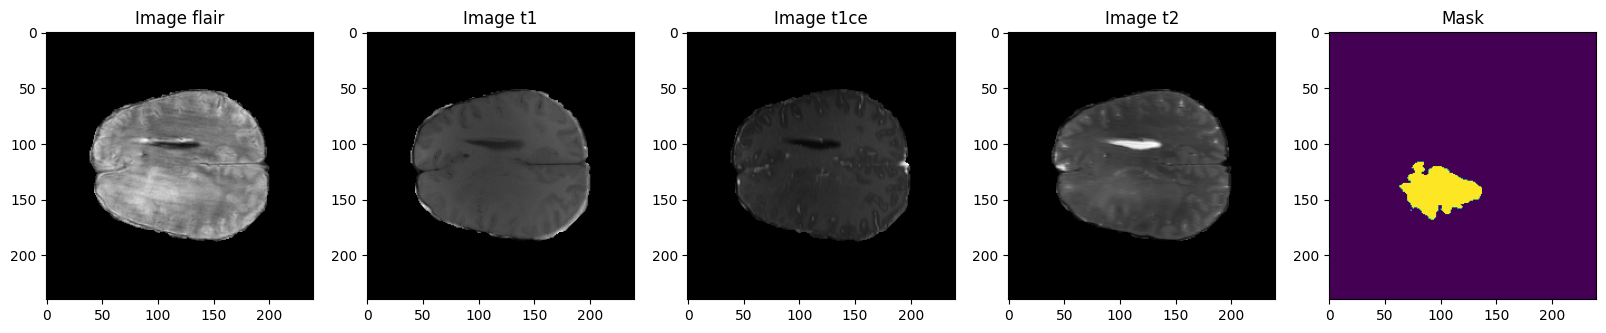

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

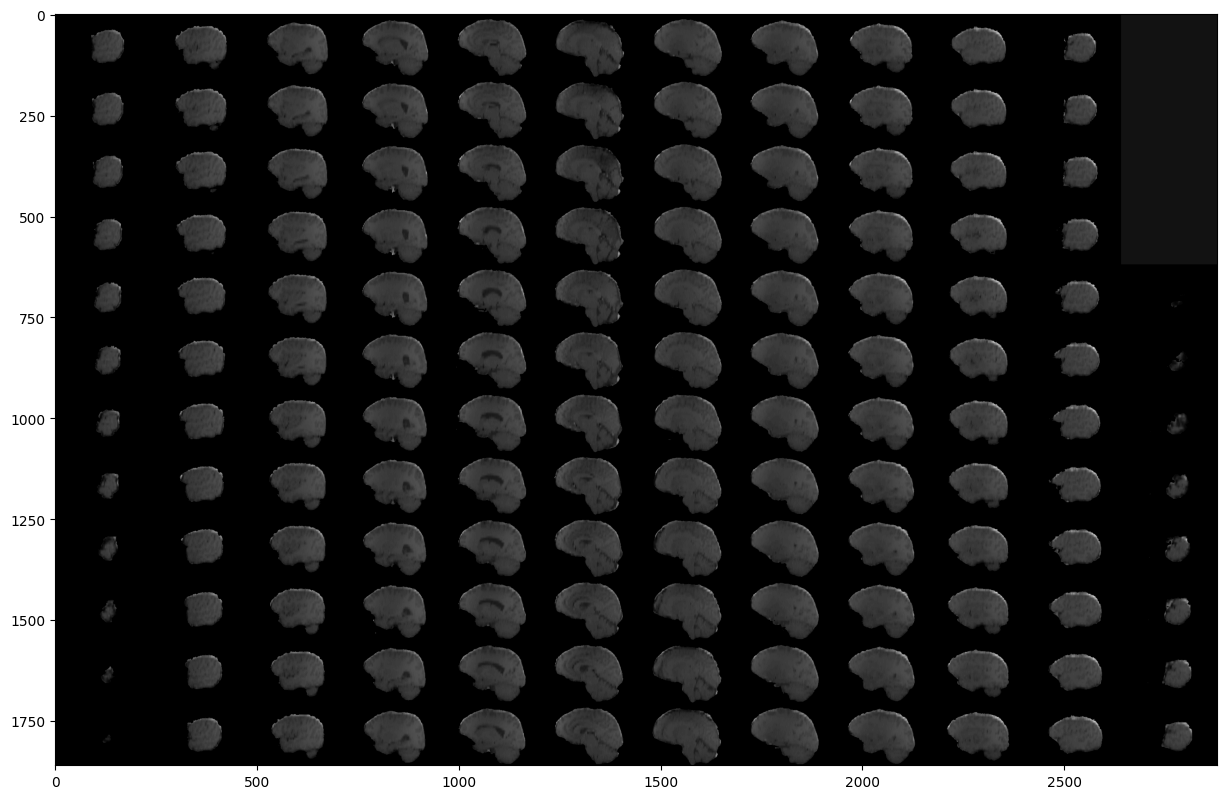

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

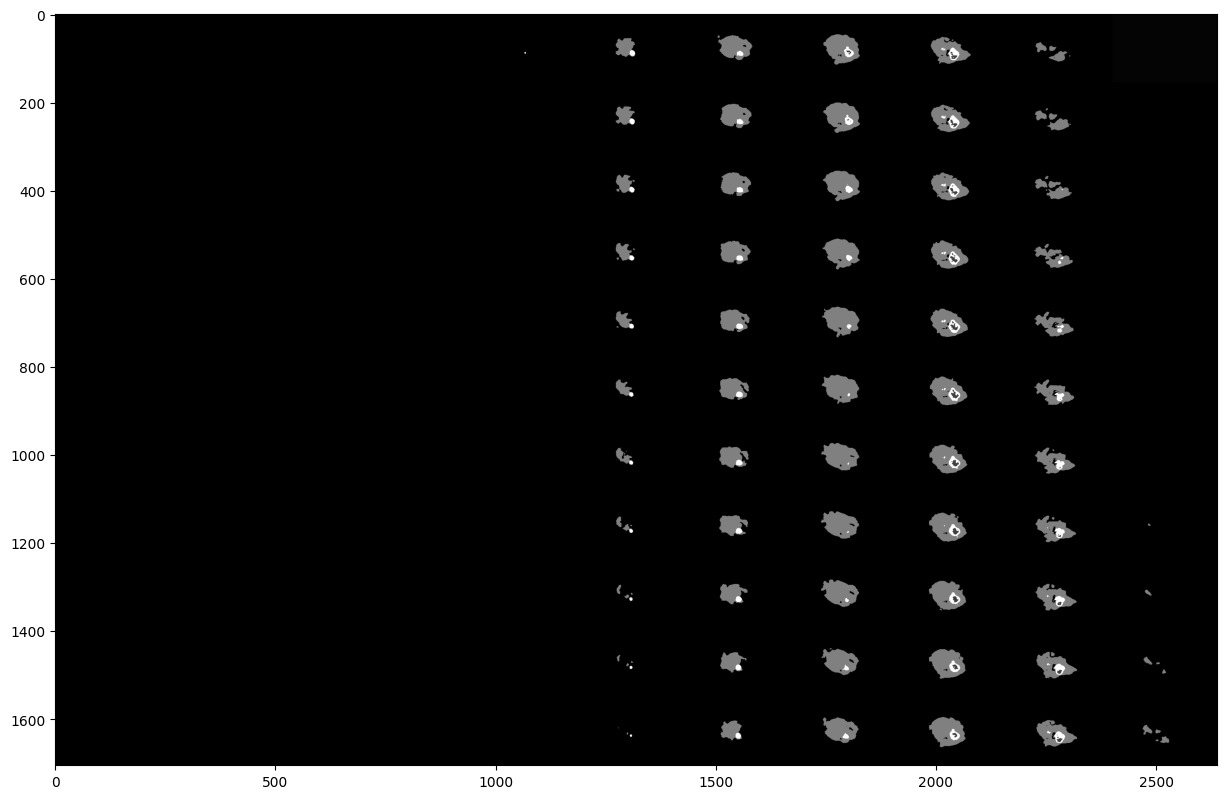

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

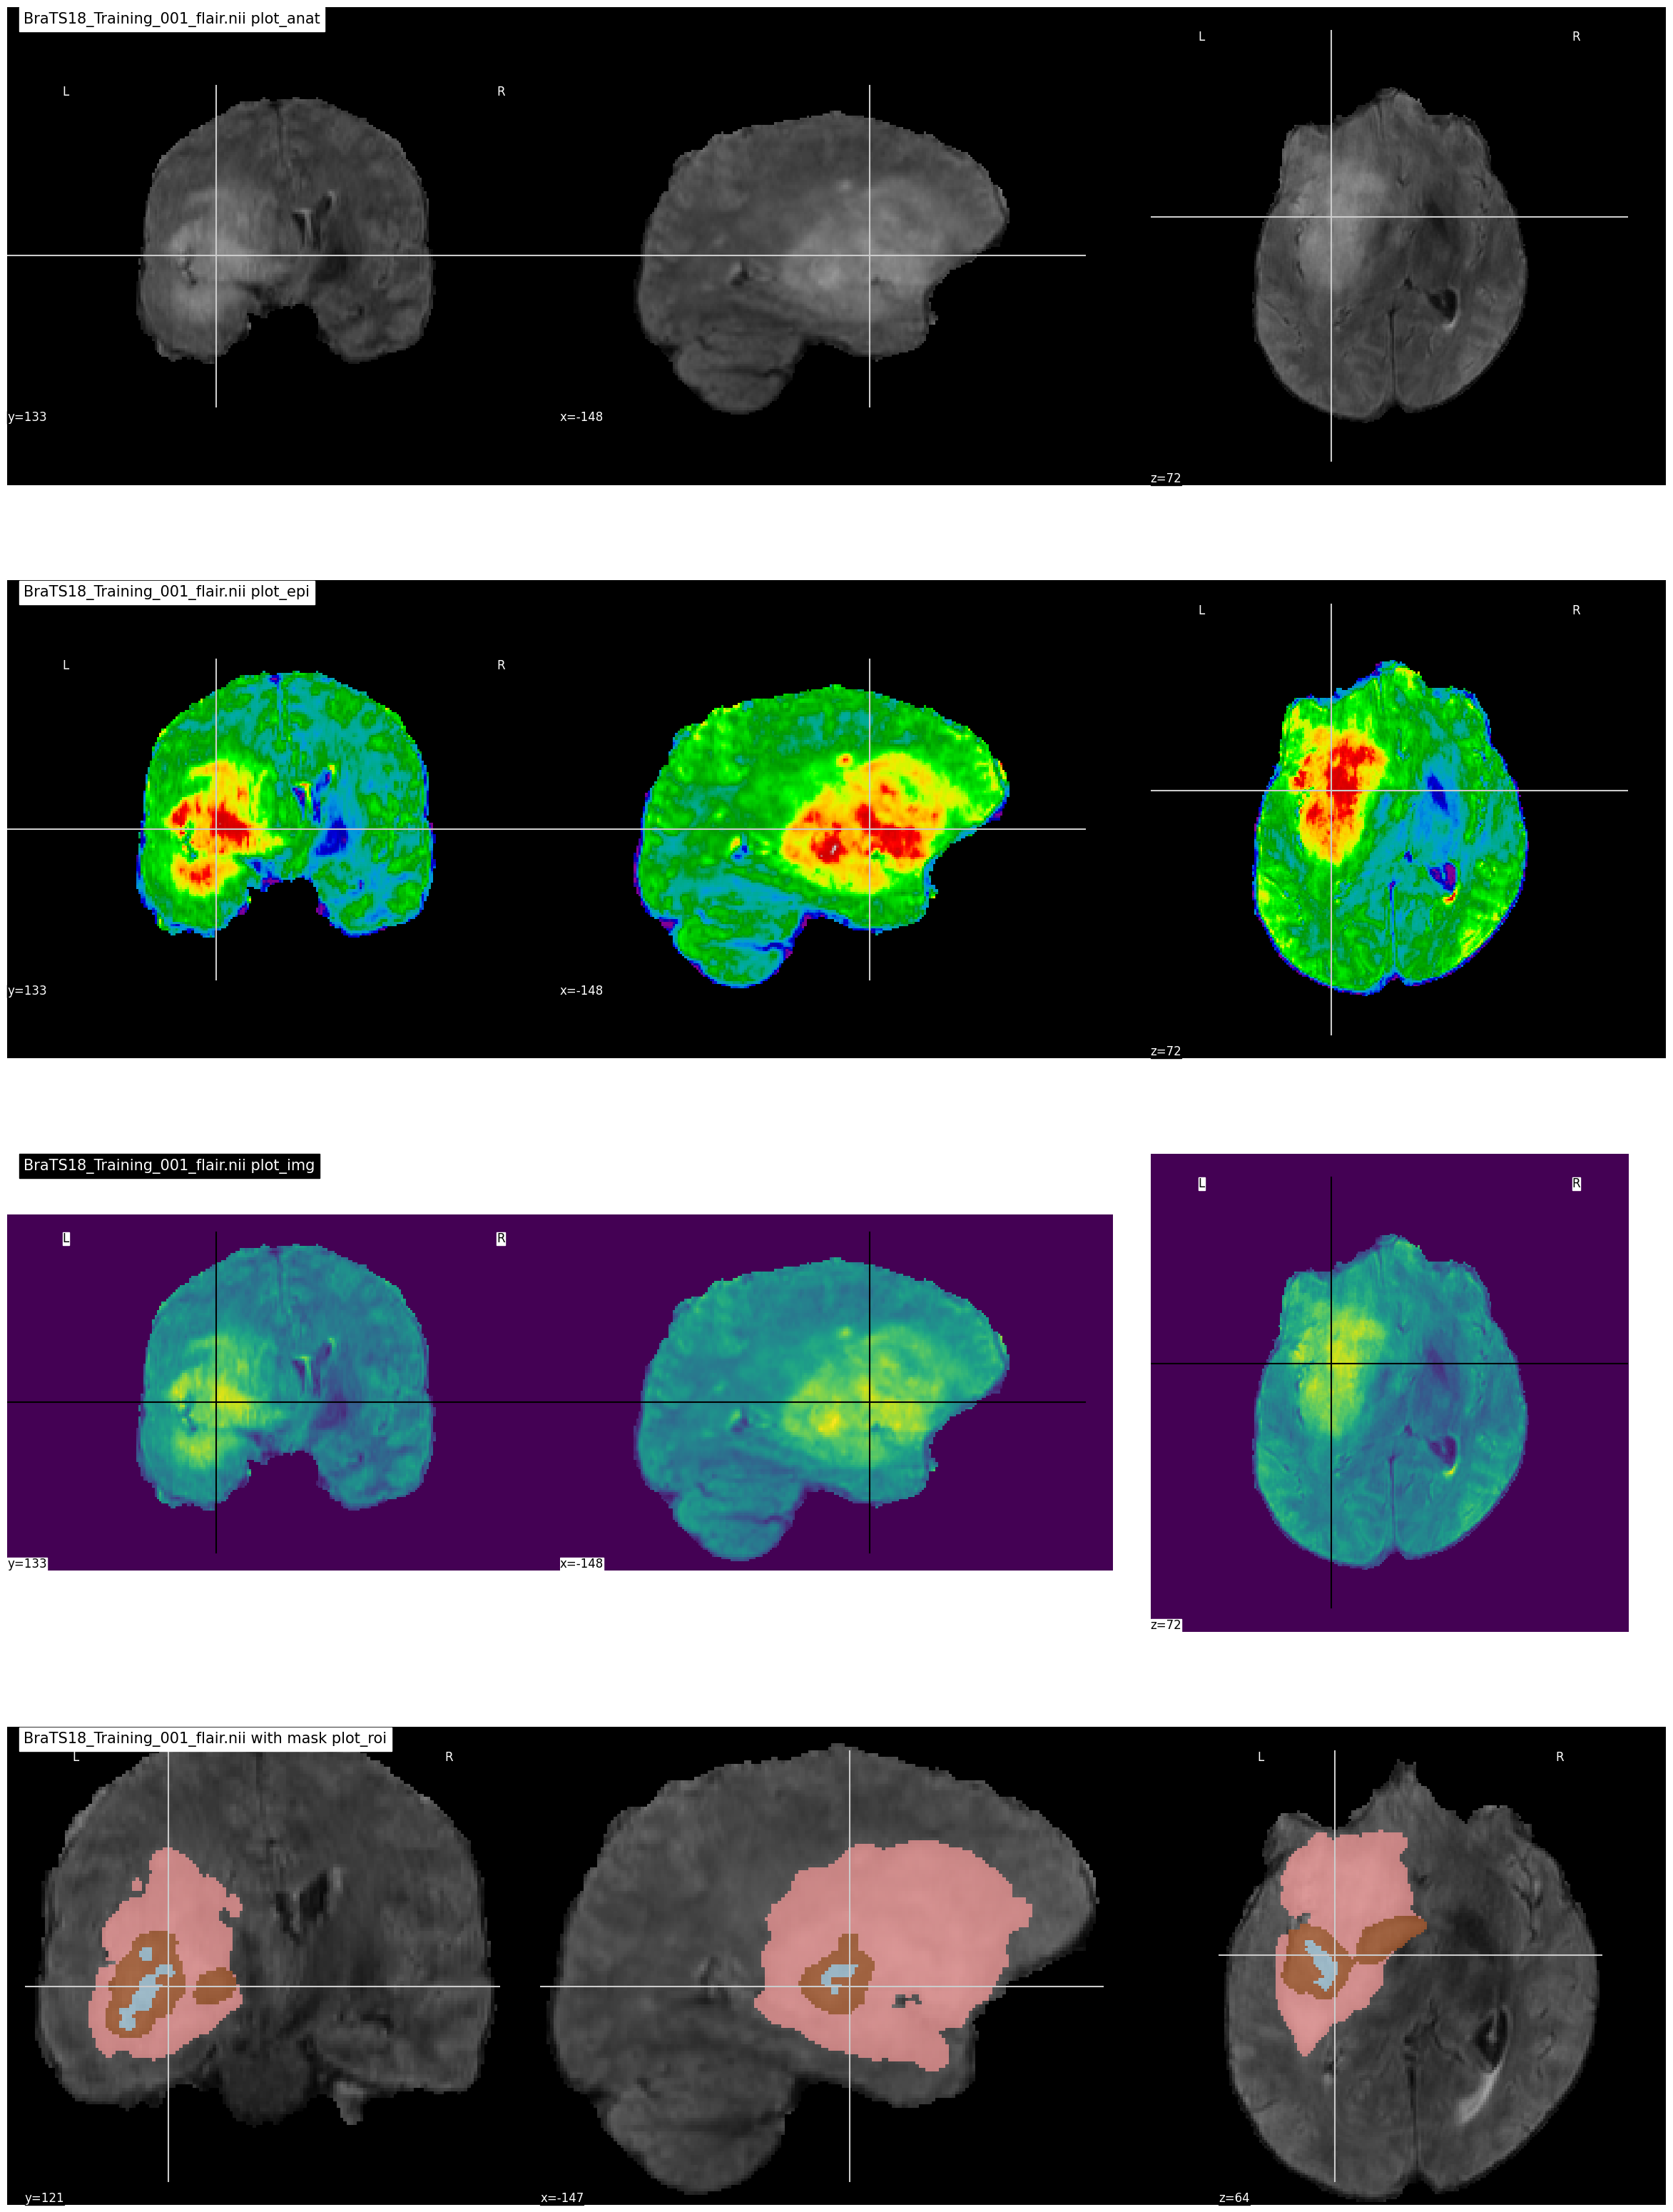

In [ ]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + '/BraTS2021_00019/BraTS2021_00019_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model

def attention_block_2d(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    f = tf.keras.layers.Add()([theta_x, phi_g])
    f = tf.keras.layers.Activation('relu')(f)
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = tf.keras.layers.Activation('sigmoid')(psi_f)
    att_x = tf.keras.layers.Multiply()([x, rate])
    return att_x

def build_unet_with_attention(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    att1 = attention_block_2d(conv1, conv1, 16)

    pool1 = MaxPooling2D(pool_size=(2, 2))(att1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    att2 = attention_block_2d(conv2, conv2, 32)

    pool2 = MaxPooling2D(pool_size=(2, 2))(att2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    att3 = attention_block_2d(conv3, conv3, 64)

    pool3 = MaxPooling2D(pool_size=(2, 2))(att3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    att4 = attention_block_2d(conv4, conv4, 128)

    pool4 = MaxPooling2D(pool_size=(2, 2))(att4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    return drop5

def build_decoder(drop5, ker_init, dropout):
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(drop5))
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv6))
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv7))
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv8))
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)

    return conv10

IMG_SIZE = 256  # Set according to your requirement
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
#
pool4 = build_unet_with_attention(input_layer, 'he_normal', 0.2)
output_layer = build_decoder(pool4, 'he_normal', 0.2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [ ]:
# def build_unet(inputs, ker_init, dropout):
#     conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
#     conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

#     pool = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
#     conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
#     conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
#     drop5 = Dropout(dropout)(conv5)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

#     up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
#     merge = concatenate([conv1,up], axis = 3)
#     conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
#     conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

#     conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

#     return Model(inputs = inputs, outputs = conv10)

# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# model = build_unet(input_layer, 'he_normal', 0.2)
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


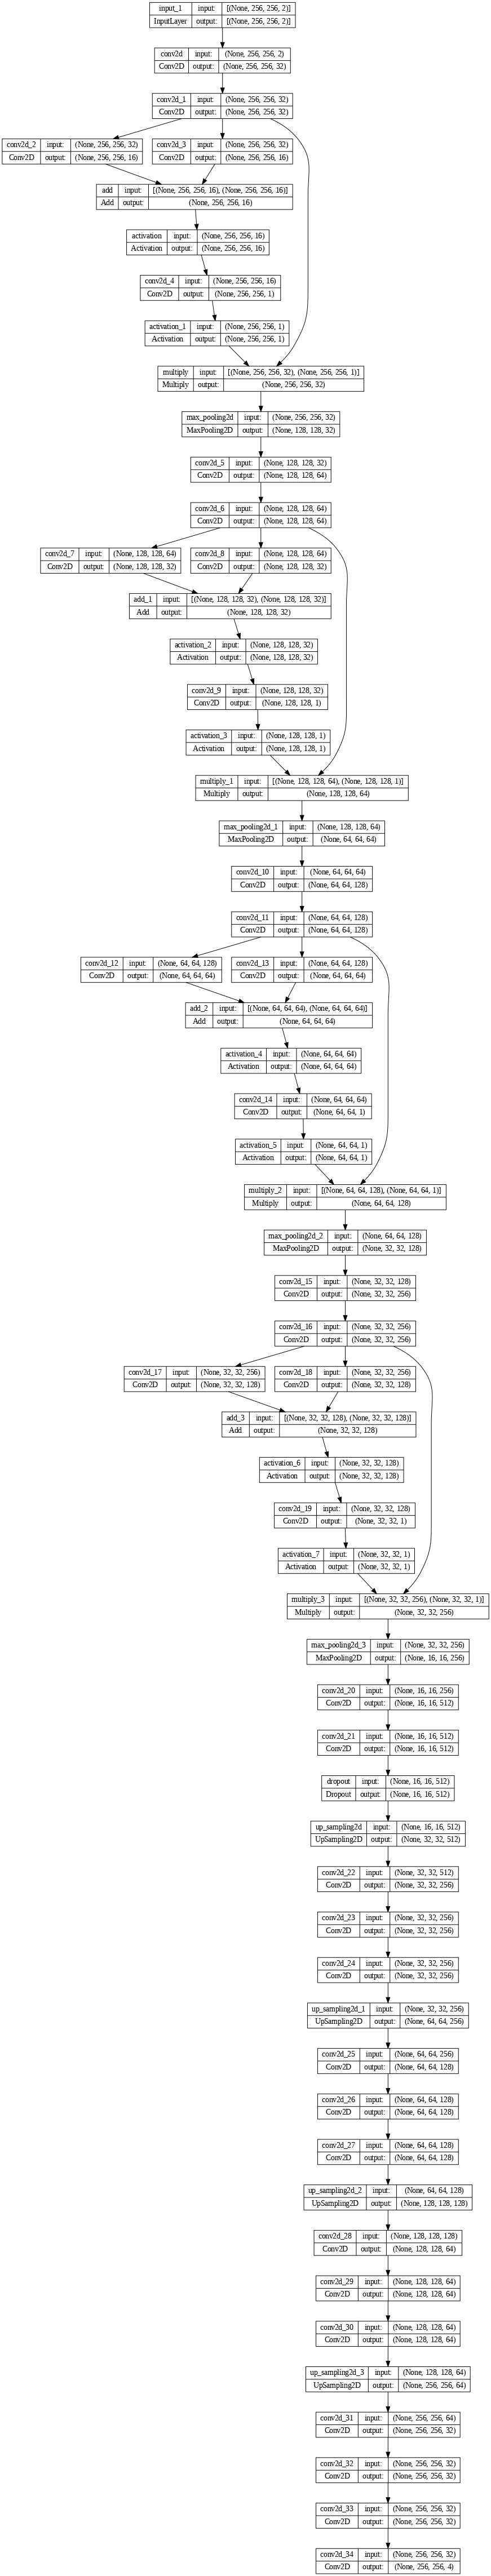

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         608       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 16)         528       ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
train_and_test_ids[0]

'BraTS2021_00000'

In [ ]:
train_ids[0]

'BraTS2021_00077'

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

137
41
25


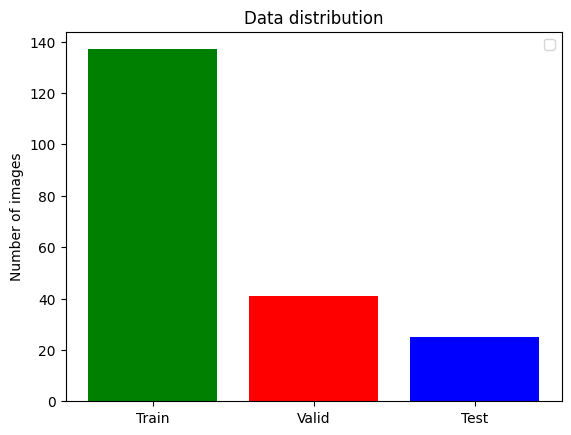

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

showDataLayout()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2021_2D_UNet.log')

history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )

Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9760 - mean_io_u_6: 0.5944 - dice_coef: 0.2672 - precision: 0.9695 - sensitivity: 0.9417 - specificity: 0.9947 - dice_coef_necrotic: 0.0419 - dice_coef_edema: 0.1398 - dice_coef_enhancing: 0.0577
Epoch 1: val_accuracy improved from -inf to 0.98572, saving model to 3D-UNet-2018-weights-improvement-01-0.986.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 244s 2s/step - loss: 0.1808 - accuracy: 0.9760 - mean_io_u_6: 0.5944 - dice_coef: 0.2672 - precision: 0.9695 - sensitivity: 0.9417 - specificity: 0.9947 - dice_coef_necrotic: 0.0419 - dice_coef_edema: 0.1398 - dice_coef_enhancing: 0.0577 - val_loss: 0.0988 - val_accuracy: 0.9857 - val_mean_io_u_6: 0.3599 - val_dice_coef: 0.2779 - val_precision: 0.9923 - val_sensitivity: 0.9616 - val_specificity: 0.9974 - val_dice_coef_necrotic: 0.1095 - val_dice_coef_edema: 0.2583 - val_dice_coef_enhancing: 0.1502
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9825 - mean_io_u_6: 0.5974 - dice_coef: 0.2883 - precision: 0.9848 - sensitivity: 0.9812 - specificity: 0.9949 - dice_coef_necrotic: 0.0740 - dice_coef_edema: 0.2089 - dice_coef_enhancing: 0.0819
Epoch 2: val_accuracy improved from 0.98572 to 0.98574, saving model to 3D-UNet-2018-weights-improvement-02-0.986.hdf5
137/137 [==============================] - 213s 

In [ ]:
model.save("model_2021_2D_UNet.h5")

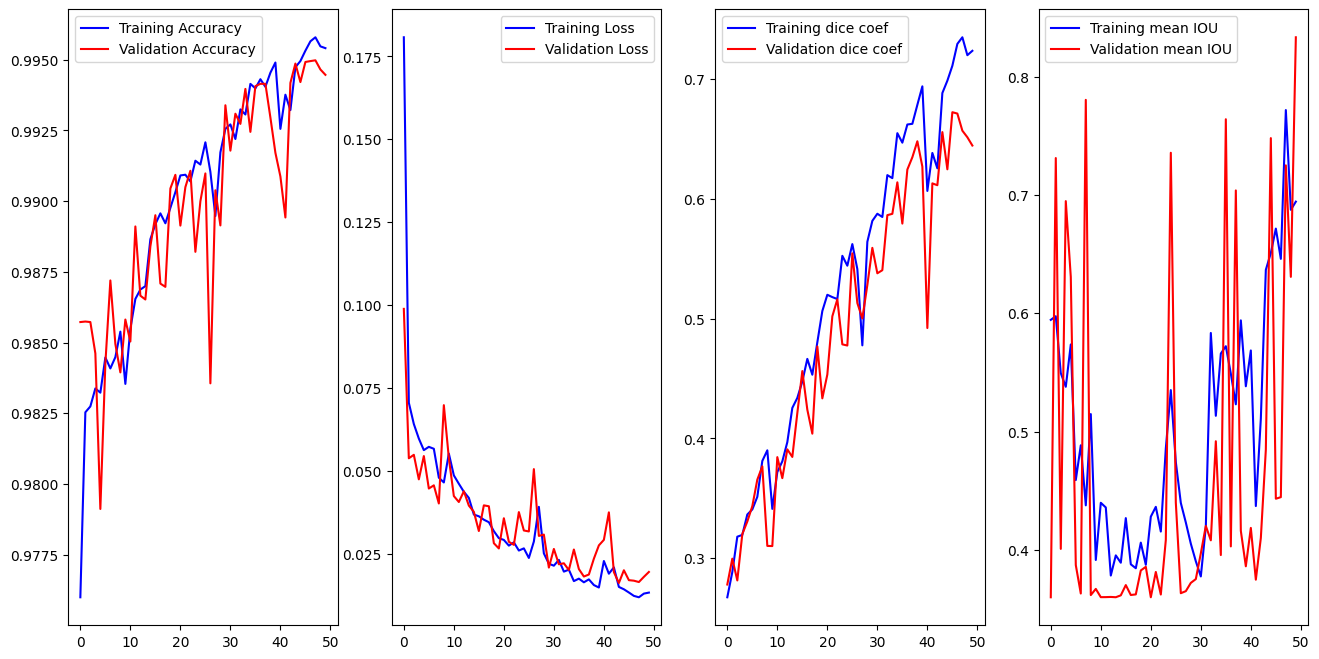

In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('/content/model_2021_2D_UNet (1).h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_2021_2D_UNet.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_6'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_6'],'r',label='Validation mean IOU')
ax[3].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [ ]:
# /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

In [ ]:
test_ids[0]

'BraTS2021_00172'

In [ ]:
TRAIN_DATASET_PATH +"/"+ test_ids[0] + "/" + test_ids[0] + '_flair.nii'

'/content/drive/MyDrive/DATASET/BraTS2021_00172/BraTS2021_00172_flair.nii'

In [ ]:
rmdir /content/drive/MyDrive/DATASET/.ipynb_checkpoints

In [ ]:
csv_logger = CSVLogger('./evaluation_50.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])


print("test loss, test acc:", results)

Evaluate on test data
25/25 [==============================] - 92s 3s/step - loss: 0.0137 - accuracy: 0.9953 - mean_io_u_6: 0.8343 - dice_coef: 0.7396 - precision: 0.9951 - sensitivity: 0.9942 - specificity: 0.9983 - dice_coef_necrotic: 0.7627 - dice_coef_edema: 0.8467 - dice_coef_enhancing: 0.8736
test loss, test acc: [0.013700812123715878, 0.9952878952026367, 0.8342684507369995, 0.7395539879798889, 0.9950570464134216, 0.994167685508728, 0.9983274340629578, 0.7627275586128235, 0.84670090675354, 0.8735601902008057]
